*DISCLAIMER: This notebook was created solely for studying purposes, this must not be used for any real medical classification!*<br><br>



<span style="font-size:20px">**Brain Tumor Classification**</span>

This Jupyter Notebook contains an implementation of a deep learning model for brain tumor classification using MRI scans. 

**Dataset**

The dataset used in this notebook consists of a collection of MRI scans of brain tumors.
Dataset  https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

**Model Architecture**

The deep learning model employed in this notebook utilizes convolutional neural networks (CNNs) to extract meaningful features from the MRI scans. It is trained on a set of labeled data. The model architecture includes multiple layers of convolution, pooling, and fully connected layers.

**Training and Evaluation**

The notebook provides code for preprocessing the MRI scans and splitting the dataset into training, evaluation and testing sets. The model is trained on the training set, each epoch is evaluated on evaluation set. The testing set assess its classification performance. Accuracy, precision, recall, and F1-score metrics are used to measure the model's performance.

**Used Libraries**

- Tensorflow
- Numpy
- OpenCV 
- Sklearn
- Matplotlib


**Load libraries**

In [56]:
#Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import imutils
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import random

#Set Seeds and print tf version
print("Tensorflow version: ", tf.__version__)
np.random.seed(7788)
tf.random.set_seed(7788)

Tensorflow version:  2.11.0


**Load all images, get labels and split data in train, evaluation and test set**

In [57]:
# Define the path
IMG_PATH = './brain_tumor_dataset/'

total_images = []
directory_names = os.listdir(IMG_PATH)

for folder in directory_names:
    folder_path = os.path.join(IMG_PATH, folder)
    print(folder_path)
    for filename in os.listdir(folder_path):
        #print(filename)
        total_images.append(os.path.join(folder_path, filename))
print("\ntotal images: ",total_images[:2])

./brain_tumor_dataset/no
./brain_tumor_dataset/yes

total images:  ['./brain_tumor_dataset/no\\1 no.jpeg', './brain_tumor_dataset/no\\10 no.jpg']


In [58]:
# Create labels based on file name.
labels = [1 if '/yes' in filename else 0 for filename in total_images]
print(labels[:2])

[0, 0]


In [59]:
#Split data in train, validation and test split
X_train_val, X_test, y_train_val, y_test = train_test_split(total_images, labels, test_size=0.1, random_state=7788,shuffle=True,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=7788,shuffle=True,stratify=y_train_val)

In [60]:
def PrintLabelRatio(data,description):
    print("Data:", description)
    print(" - Positive: ", np.sum(data))
    print(" - Negative: ",-np.sum(data)+len(data))
    
PrintLabelRatio(labels,"Total Dataset")
PrintLabelRatio(y_train,"Train Dataset")
PrintLabelRatio(y_val,"Validation Dataset")
PrintLabelRatio(y_test,"Test Dataset")

Data: Total Dataset
 - Positive:  155
 - Negative:  98
Data: Train Dataset
 - Positive:  111
 - Negative:  70
Data: Validation Dataset
 - Positive:  28
 - Negative:  18
Data: Test Dataset
 - Positive:  16
 - Negative:  10


Displayed images: 19 - 20
['./brain_tumor_dataset/no\\40 no.jpg', './brain_tumor_dataset/no\\N20.JPG']
['./brain_tumor_dataset/yes\\Y103.jpg', './brain_tumor_dataset/yes\\Y188.jpg']


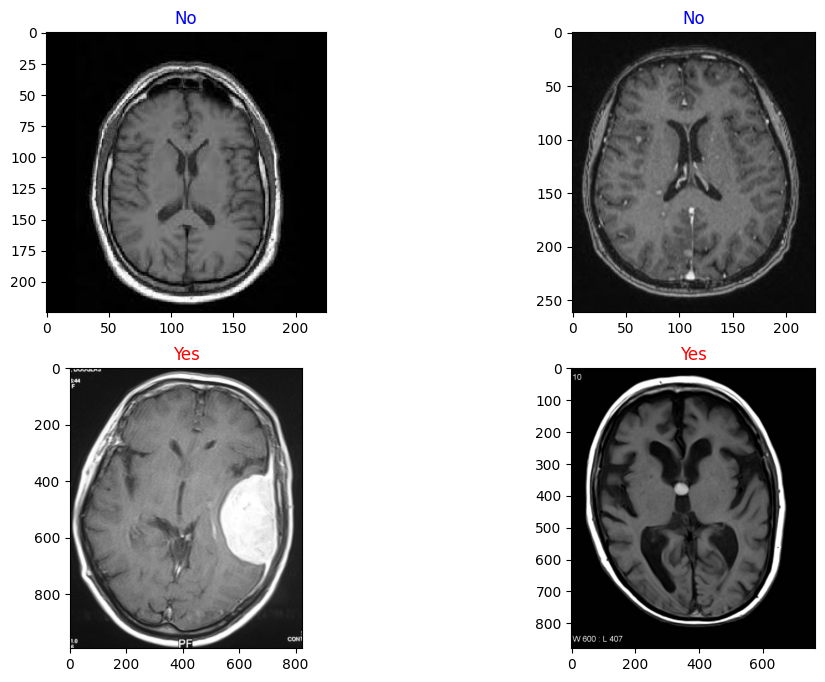

In [61]:
%matplotlib inline

sample = random.randint(0, 20)
print(f"Displayed images: {sample} - {sample+1}")

# Define the labels and their corresponding colors
labels = {0: 'No', 1: 'Yes'}
colors = {0: 'blue', 1: 'red'}

# Plot some images from the train set for each label based on sample random number
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for i, label in enumerate([0, 1]):
    images = [x for x, y in zip(X_train, y_train) if y == label][sample:sample+2]
    print(images)
    for j, image_path in enumerate(images):
        img = plt.imread(image_path)
        axs[i, j].imshow(img)
        axs[i, j].set_title(labels[label], color=colors[label])
plt.show()

**Preprocess data**

In [62]:
#Define custom preprocessing function
def preprocess_images(images):
    preprocessed_images = []
    
    for i, img_path in enumerate(images):

        img = cv.imread(img_path)
        img = cv.resize(
                    img,
                    dsize=(120,120),
                    interpolation=cv.INTER_CUBIC
                )
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        gray = cv.GaussianBlur(gray, (5, 5), 0)
        thresh = cv.threshold(gray, 110, 255, cv.THRESH_BINARY)[1]
        thresh = cv.erode(thresh, None, iterations=4)
        thresh = cv.dilate(thresh, None, iterations=4)

        # find contours and draw them
        contours = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        contours = imutils.grab_contours(contours)
        cv.drawContours(img, contours, -1, (0, 255, 0), 1)

        preprocessed_images.append(img)
    return np.array(preprocessed_images)

In [63]:
#Preprocess all data
X_train_pre = preprocess_images(X_train)
X_val_pre = preprocess_images(X_val)
X_test_pre = preprocess_images(X_test)


Tumor: Yes


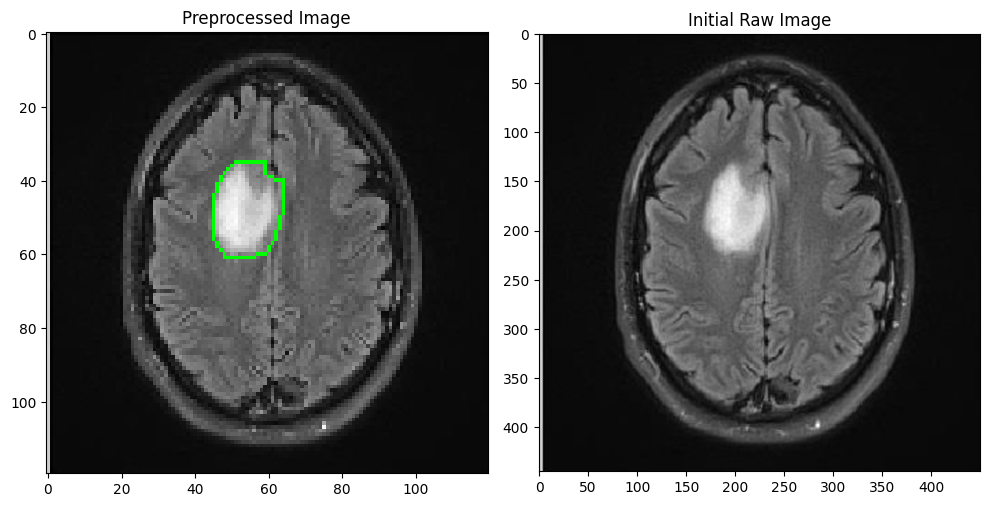

In [64]:
#Plot preprocessed image with contours on a train set
def DisplayImages(number):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns

    # Plot preprocessed image
    print("\nTumor: Yes" if y_train[number]==1 else "Tumor: No")
    img = X_train_pre[number]
    axes[0].imshow(img)
    axes[0].set_title('Preprocessed Image')

    # Plot initial image
   
    img = plt.imread(X_train[number])
    axes[1].imshow(img)
    axes[1].set_title('Initial Raw Image')

    plt.tight_layout()
    plt.show()

DisplayImages(20)

**Model Training**

In [65]:
tf.random.set_seed(7788)

early_stopping = EarlyStopping(monitor='val_recall',patience=3, restore_best_weights=True)#

reduce_lr = ReduceLROnPlateau(monitor='val_recall', 
                              factor=0.2,
                              patience=2, 
                              min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='val_recall', 
                             filepath='./cnn_model_checkpoint.h5', 
                             save_best_only=True)

callbacks = [early_stopping,reduce_lr,model_checkpoint]


def recall(y_true, y_pred):
    true_positives = tf.math.count_nonzero(tf.math.logical_and(y_true == 1, tf.round(y_pred) == 1))
    possible_positives = tf.math.count_nonzero(y_true == 1)
    return tf.cast(true_positives, tf.float32) / (tf.cast(possible_positives, tf.float32) + tf.keras.backend.epsilon())


In [66]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=30,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.3,
                                  zoom_range=0.3,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train_pre,
                                     y_train,
                                     batch_size=16,
                                     shuffle=True,
                                     seed=7788)

validation_generator =  test_datagen.flow(X_val_pre,
                                     y_val,
                                     batch_size=4,
                                     shuffle=True,
                                     seed=7788)

In [67]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf


#Functional API
input_layer = tf.keras.Input(shape=(120, 120,3))
x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.009, beta_2=0.999, epsilon=1e-07, amsgrad=True)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[recall])

model.fit(train_generator,epochs=10,verbose=1,validation_data=validation_generator,callbacks=[callbacks])

Epoch 1/10
12/12 [==============================] - 4s 205ms/step - loss: 0.6739 - recall: 0.6850 - val_loss: 49.5704 - val_recall: 0.7153 - lr: 0.0010
Epoch 2/10
12/12 [==============================] - 3s 271ms/step - loss: 0.7530 - recall: 0.7835 - val_loss: 297.4831 - val_recall: 1.0000 - lr: 0.0010
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 0.7180 - recall: 0.8096
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
12/12 [==============================] - 3s 239ms/step - loss: 0.7180 - recall: 0.8096 - val_loss: 190.6574 - val_recall: 1.0000 - lr: 0.0010
Epoch 4/10
12/12 [==============================] - 3s 274ms/step - loss: 0.6838 - recall: 0.9917 - val_loss: 64.9216 - val_recall: 1.0000 - lr: 2.0000e-04


**Evaluate model on test set**

In [68]:
predictions = model.predict(X_test_pre)
predictions = np.where(predictions > 0.5, 1, 0)
y_pred = predictions.flatten()
y_pred

1/1 [==============================] - 0s 305ms/step


array([1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [69]:
y_true = np.array(y_test)
y_true

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1])

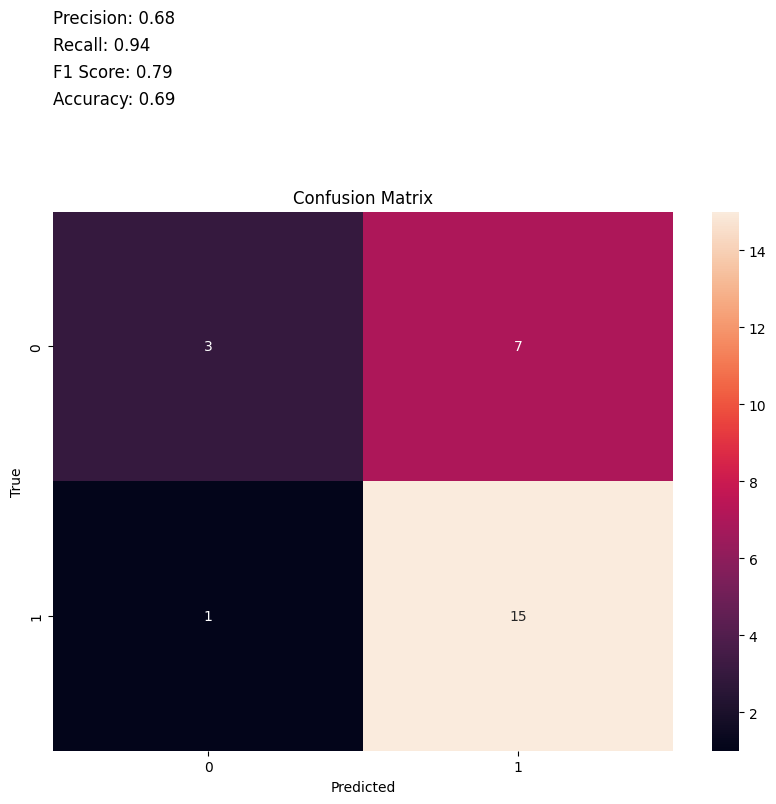

In [70]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate precision and recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Add precision and recall values to the plot
plt.text(0, -0.6, f'Recall: {recall:.2f}', fontsize=12, ha='left')
plt.text(0, -0.7, f'Precision: {precision:.2f}', fontsize=12, ha='left')
plt.text(0, -0.5, f'F1 Score: {f1:.2f}', fontsize=12, ha='left')
plt.text(0, -0.4, f'Accuracy: {accuracy:.2f}', fontsize=12, ha='left')

plt.show()

**Make Prediction and Display Images**


Tumor in the image: Yes
Model Prediction: Yes


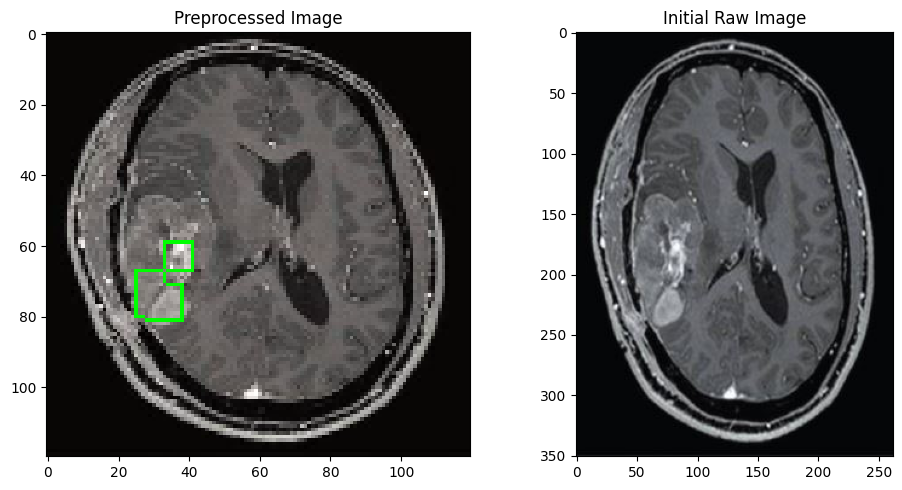

In [71]:
#Plot preprocessed image with contours
def PredictDisplay(number,df,ylabels,initial_df):

    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # 1 row, 2 columns
    
    #Make prediction
    img_input = tf.expand_dims(df[number], axis=0)
    prediction = model.predict(img_input,verbose=0)
    predicted_test = np.where(prediction > 0.5, 1, 0)
    pred = predicted_test[0][0]
    
    print("\nTumor in the image: Yes" if ylabels[number]==1 else "Tumor in the image: No")
    print("Model Prediction: Yes" if pred==1 else "Model Prediction: No")
    
    img = df[number]
    axes[0].imshow(img)
    axes[0].set_title('Preprocessed Image')

    # Plot initial image
    img = plt.imread(initial_df[number])
    axes[1].imshow(img)
    axes[1].set_title('Initial Raw Image')

    plt.tight_layout()
    plt.show()

PredictDisplay(1,X_test_pre,y_test,X_test)